# Stepik ML contest

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

In [566]:
events_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
events_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [3]:
# description
# step_id - id стэпа
# user_id - анонимизированный id юзера
# timestamp - время наступления события в формате unix date
# action - событие, возможные значения:
# discovered - пользователь перешел на стэп
# viewed - просмотр шага,
# started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
# passed - удачное решение практического шага

In [567]:
submissions_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [5]:
# description
# step_id - id стэпа
# timestamp - время отправки решения в формате unix date
# submission_status - статус решения
# user_id - анонимизированный id юзера

### Data preparation

In [568]:
events_train['date'] = pd.to_datetime(events_train.timestamp, unit='s')

In [569]:
events_train['day'] = events_train.date.dt.date
events_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


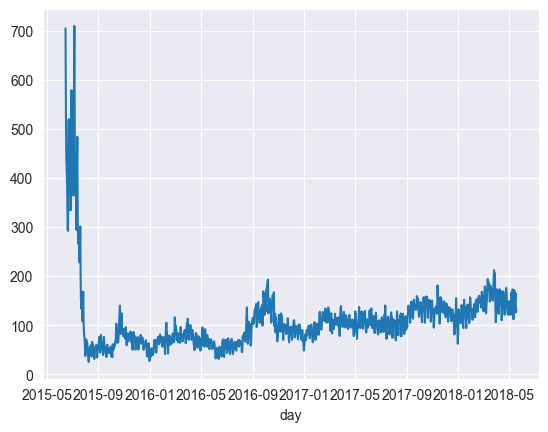

In [173]:
# считаем кол-во уникальных пользователей
events_train.groupby('day')['user_id'].nunique().plot()
plt.show()

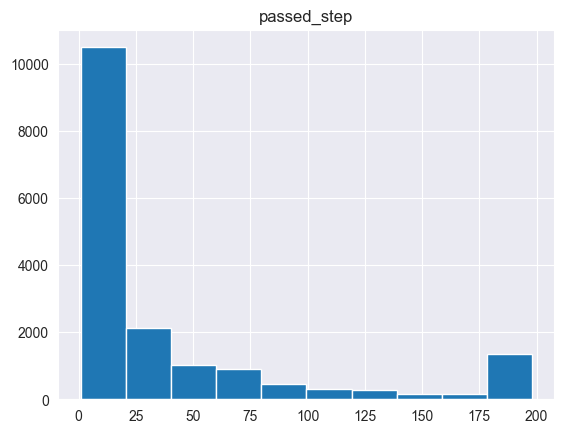

In [8]:
events_train[events_train.action == 'passed'].groupby('user_id').aggregate({'step_id': 'count'}).rename(columns={'step_id': 'passed_step'}).hist()
plt.show()

In [175]:
events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


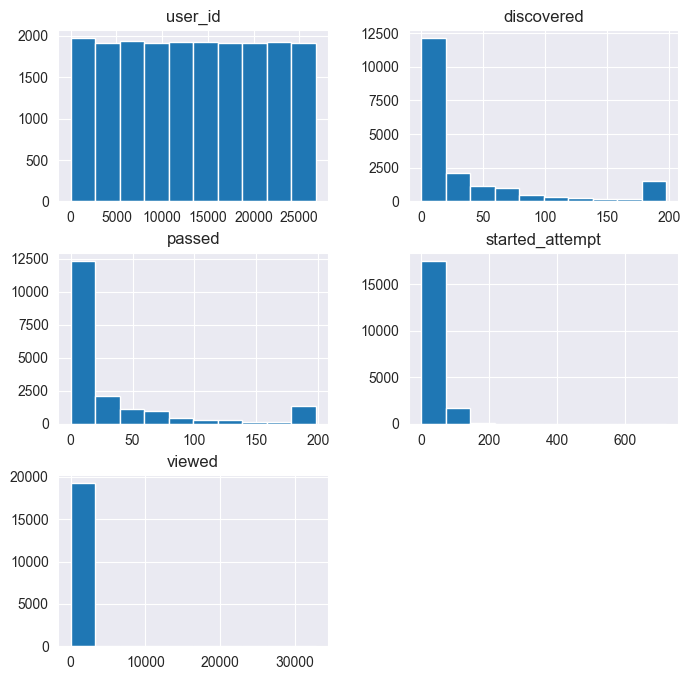

In [176]:
events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().hist(figsize=(8, 8))
plt.show()

In [570]:
submissions_train['date'] = pd.to_datetime(submissions_train.timestamp, unit='s')
submissions_train.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


In [571]:
submissions_train['day'] = submissions_train.date.dt.date
submissions_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [179]:
submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


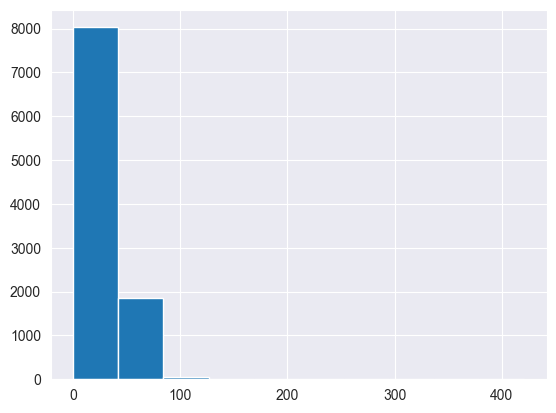

In [180]:
submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().correct.hist()
plt.show()

### Задача
Отсечь пользователей, которые не закончили курс. Допустим, если пользователь не возвращался к курсу какое-то время, то с высокой вероятностью он уже не вернется для завершения курса.

**Шаг 1**
Найдем временные промежутки между прохождением степов, далее посмотрим в какой интервал укладывается большинство пользователей.

In [572]:
# для работы нам потребуется 3 колонки
visits_gap = events_train[['user_id', 'day', 'timestamp']]
visits_gap.head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
1,17632,2015-06-15,1434340848
2,17632,2015-06-15,1434340848
3,17632,2015-06-15,1434340895
4,17632,2015-06-15,1434340895


In [573]:
# оставляем только уникальные записи timestamp в рамках одного пользователя и дня
visits_gap = visits_gap.drop_duplicates(subset=['user_id', 'day'])
visits_gap.head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


In [574]:
# создаем список с timestamp действий пользователя
visits_gap = visits_gap.groupby('user_id')['timestamp'].apply(list)
visits_gap.head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [575]:
# считаем разницу между событиями
visits_gap = visits_gap.apply(np.diff)
visits_gap.head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [576]:
# извлекаем из серии значения
visits_gap = visits_gap.values
visits_gap

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [577]:
# трансформируем события в плоский список
visits_gap = pd.Series(np.concatenate(visits_gap, axis=0))
visits_gap

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int64

In [578]:
# меняем формат в дни
visits_gap = visits_gap / (24 * 60 * 60)

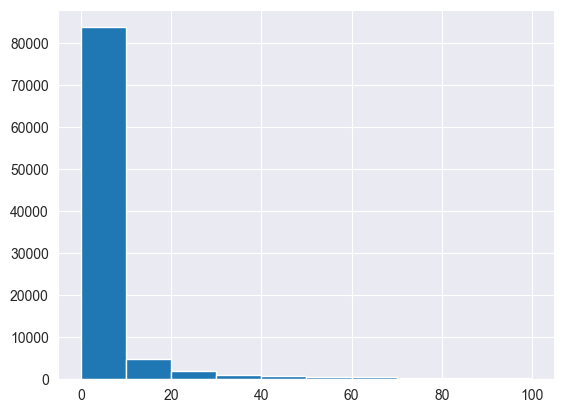

In [261]:
# строим гистограмму
visits_gap[visits_gap < 100].hist()
plt.show()

In [262]:
# смотрим в какой интервал времени укладывается 90% событий
visits_gap.quantile(0.90)

18.325995370370403

In [579]:
is_gone_time_gap = visits_gap.quantile(0.90)

**Шаг 2**
Смержим наши данные в таблицу и дополним ее необходимыми значениями

In [580]:
events_pivot = events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
events_pivot.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [581]:
submissions_pivot = submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()
submissions_pivot.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [582]:
users_data = events_pivot.merge(submissions_pivot, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,10,2.0,0.0
2,3,91,87,30,192,29.0,23.0
3,5,11,11,4,12,2.0,2.0
4,7,1,1,0,1,0.0,0.0


In [583]:
last_timestamp = events_train[['user_id','timestamp']].groupby('user_id').aggregate({'timestamp':'max'}).reset_index().rename(columns={'timestamp': 'last_timestamp'})

In [584]:
last_timestamp.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [585]:
users_data = users_data.merge(last_timestamp, on='user_id', how='outer').fillna(0)
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966
2,3,91,87,30,192,29.0,23.0,1444581588
3,5,11,11,4,12,2.0,2.0,1499859939
4,7,1,1,0,1,0.0,0.0,1521634660


In [586]:
now_t = users_data.last_timestamp.max()
now_t

1526772811

In [587]:
users_data['is_gone'] = now_t - users_data['last_timestamp']  > is_gone_time_gap
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone
0,1,1,0,0,1,0.0,0.0,1472827464,True
1,2,9,9,2,10,2.0,0.0,1519226966,True
2,3,91,87,30,192,29.0,23.0,1444581588,True
3,5,11,11,4,12,2.0,2.0,1499859939,True
4,7,1,1,0,1,0.0,0.0,1521634660,True


In [272]:
users_data['course_completed'] = users_data.passed > 170
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,10,2.0,0.0,1519226966,True,False
2,3,91,87,30,192,29.0,23.0,1444581588,True,False
3,5,11,11,4,12,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [1073]:
users_data['course_completed'] = users_data.passed > 40
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed,first_timestamp_x,completion_time,first_timestamp_y,first_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464,True,False,1472827464,0.000000e+00,1472827464,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966,True,False,1514383364,7.265403e+08,1514383364,1514383364
2,3,91,87,30,192,29.0,23.0,1444581588,True,True,1434358476,1.533467e+09,1434358476,1434358476
3,5,11,11,4,12,2.0,2.0,1499859939,True,False,1466156809,5.055470e+09,1466156809,1466156809
4,7,1,1,0,1,0.0,0.0,1521634660,True,False,1521634660,0.000000e+00,1521634660,1521634660


In [1074]:
users_data.groupby('course_completed')['course_completed'].count()

course_completed
False    14596
True      4638
Name: course_completed, dtype: int64

In [1075]:
users_data

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed,first_timestamp_x,completion_time,first_timestamp_y,first_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464,True,False,1472827464,0.000000e+00,1472827464,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966,True,False,1514383364,7.265403e+08,1514383364,1514383364
2,3,91,87,30,192,29.0,23.0,1444581588,True,True,1434358476,1.533467e+09,1434358476,1434358476
3,5,11,11,4,12,2.0,2.0,1499859939,True,False,1466156809,5.055470e+09,1466156809,1466156809
4,7,1,1,0,1,0.0,0.0,1521634660,True,False,1521634660,0.000000e+00,1521634660,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,8,8,1,9,1.0,0.0,1517495987,True,False,1451484016,9.901796e+09,1451484016,1451484016
19230,26793,1,0,1,1,0.0,0.0,1510225034,True,False,1510225031,4.500000e+02,1510225031,1510225031
19231,26794,69,69,34,180,33.0,9.0,1512035039,True,True,1495287049,2.512198e+09,1495287049,1495287049
19232,26797,10,10,2,13,2.0,0.0,1509995096,True,False,1508425316,2.354670e+08,1508425316,1508425316


### Задача
Предсказать успешность прохождения курса на основе поведения студента в первые несколько дней

In [201]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19234 entries, 0 to 19233
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           19234 non-null  int64  
 1   discovered        19234 non-null  int64  
 2   passed            19234 non-null  int64  
 3   started_attempt   19234 non-null  int64  
 4   viewed            19234 non-null  int64  
 5   correct           19234 non-null  float64
 6   wrong             19234 non-null  float64
 7   last_timestamp    19234 non-null  int64  
 8   is_gone           19234 non-null  bool   
 9   course_completed  19234 non-null  bool   
dtypes: bool(2), float64(2), int64(6)
memory usage: 1.4 MB


In [202]:
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,10,2.0,0.0,1519226966,True,False
2,3,91,87,30,192,29.0,23.0,1444581588,True,False
3,5,11,11,4,12,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [691]:
first_timestamp = events_train.groupby('user_id').aggregate({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'first_timestamp'})

In [692]:
first_timestamp.head()

,user_id,first_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [693]:
users_data = users_data.merge(first_timestamp, on='user_id', how='outer').fillna(0)

In [694]:
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed,first_timestamp_x,completion_time,first_timestamp_y,first_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464,True,False,1472827464,0.000000e+00,1472827464,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966,True,False,1514383364,7.265403e+08,1514383364,1514383364
2,3,91,87,30,192,29.0,23.0,1444581588,True,True,1434358476,1.533467e+09,1434358476,1434358476
3,5,11,11,4,12,2.0,2.0,1499859939,True,False,1466156809,5.055470e+09,1466156809,1466156809
4,7,1,1,0,1,0.0,0.0,1521634660,True,False,1521634660,0.000000e+00,1521634660,1521634660


In [695]:
users_data['completion_time'] = (users_data.last_timestamp - users_data.first_timestamp_x) / 24 * 60 * 60
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed,first_timestamp_x,completion_time,first_timestamp_y,first_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464,True,False,1472827464,0.000000e+00,1472827464,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966,True,False,1514383364,7.265403e+08,1514383364,1514383364
2,3,91,87,30,192,29.0,23.0,1444581588,True,True,1434358476,1.533467e+09,1434358476,1434358476
3,5,11,11,4,12,2.0,2.0,1499859939,True,False,1466156809,5.055470e+09,1466156809,1466156809
4,7,1,1,0,1,0.0,0.0,1521634660,True,False,1521634660,0.000000e+00,1521634660,1521634660


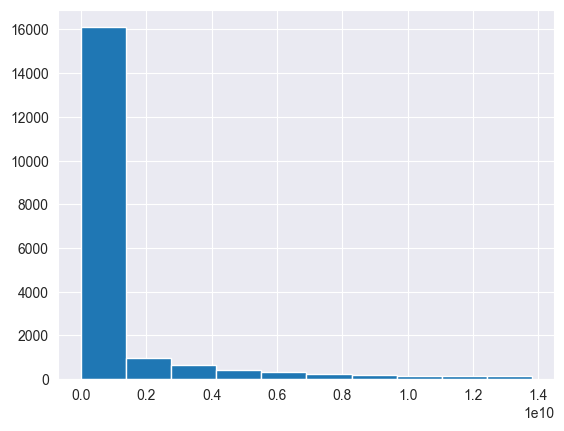

In [696]:
users_data['completion_time'].hist()
plt.show()

In [697]:
events_threshold = 2 * 24 * 60 * 60

In [611]:
# Создаем новую таблицу с событиями за первый 3 дня с первого события пользователя
events_train_first_3_days = events_train.merge(users_data[['user_id', 'first_timestamp']], on='user_id', how='left') \
    .query("(timestamp - first_timestamp) < @events_threshold")

KeyError: "['first_timestamp'] not in index"

In [751]:
events_train_first_2_days = events_train.merge(users_data[['user_id', 'first_timestamp_y']], on='user_id', how='left') \
    .query("(timestamp - first_timestamp_y) < @events_threshold")

In [752]:
events_train_first_2_days.head()

,step_id,timestamp,action,user_id,date,day,first_timestamp_y
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [212]:
events_train_first_3_days.shape

(1014980, 7)

In [699]:
events_train_first_2_days.groupby('user_id').day.nunique().max()

3

In [754]:
train_data = events_train_first_2_days.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
train_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


In [755]:
train_data = train_data.merge(submissions_pivot, on='user_id', how='outer').fillna(0)
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,9,2.0,0.0
2,3,15,15,4,20,29.0,23.0
3,5,1,1,0,1,2.0,2.0
4,7,1,1,0,1,0.0,0.0


In [1088]:
train_data.user_id

0            1
1            2
2            3
3            5
4            7
         ...  
19229    26790
19230    26793
19231    26794
19232    26797
19233    26798
Name: user_id, Length: 19233, dtype: int64

In [757]:
last_timestamp = events_train[['user_id', 'timestamp']].groupby('user_id').aggregate(
    {'timestamp': 'max'}).reset_index().rename(columns={'timestamp': 'last_timestamp'})
last_timestamp.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [758]:
train_data = train_data.merge(last_timestamp, on='user_id', how='outer').fillna(0)
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464
1,2,9,9,2,9,2.0,0.0,1519226966
2,3,15,15,4,20,29.0,23.0,1444581588
3,5,1,1,0,1,2.0,2.0,1499859939
4,7,1,1,0,1,0.0,0.0,1521634660


In [759]:
now_t = users_data.last_timestamp.max()
now_t

1526772811

In [760]:
train_data['is_gone'] = now_t - train_data['last_timestamp'] > is_gone_time_gap
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone
0,1,1,0,0,1,0.0,0.0,1472827464,True
1,2,9,9,2,9,2.0,0.0,1519226966,True
2,3,15,15,4,20,29.0,23.0,1444581588,True
3,5,1,1,0,1,2.0,2.0,1499859939,True
4,7,1,1,0,1,0.0,0.0,1521634660,True


In [761]:
train_data = train_data.merge(users_data[['user_id', 'course_completed']], on='user_id', how='outer').fillna(0)
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,9,2.0,0.0,1519226966,True,False
2,3,15,15,4,20,29.0,23.0,1444581588,True,False
3,5,1,1,0,1,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [762]:
users_data.groupby(['is_gone', 'course_completed']).aggregate({'user_id': 'count'})

user_id
is_gone course_completed         
False   False                   1
True    False               17265
        True                 1968

In [763]:
train_data = train_data.query("is_gone == True")

In [764]:
train_data.groupby(['is_gone', 'course_completed']).aggregate({'user_id': 'count'})

user_id
is_gone course_completed         
True    False               17265
        True                 1968

In [765]:
train_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,9,2.0,0.0,1519226966,True,False
2,3,15,15,4,20,29.0,23.0,1444581588,True,False
3,5,1,1,0,1,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [712]:
X = train_data.drop(['last_timestamp', 'is_gone', 'course_completed'], axis=1)

In [713]:
X = X.set_index('user_id')
X.head()

,discovered,passed,started_attempt,viewed,correct,wrong
user_id,,,,,,
1,1,0,0,1,0.0,0.0
2,9,9,2,9,2.0,0.0
3,15,15,4,20,29.0,23.0
5,1,1,0,1,2.0,2.0
7,1,1,0,1,0.0,0.0


In [274]:
y = train_data[['user_id', 'course_completed']]

In [275]:
y = y.set_index('user_id')

In [280]:
rs = np.random.seed(0)

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rs)

In [282]:
clf = DecisionTreeClassifier()

In [283]:
params={'criterion':['gini', 'entropy'], 'max_depth': range(1, 12)}

In [284]:
grid_search_cv_clf=GridSearchCV(clf, params, cv=5)

In [285]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 12)})

In [286]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=1)

In [293]:
grid_search_cv_clf.best_params_

{'criterion': 'gini', 'max_depth': 1}

In [317]:
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [318]:
best_clf.score(X_test, y_test)

0.991890205864005

In [319]:
y_pred = best_clf.predict(X_test)

In [320]:
# проверяем Precision
precision_score(y_test, y_pred)

0.9086161879895561

In [321]:
# проверяем Recall
recall_score(y_test, y_pred)

0.9886363636363636

In [302]:
y_test.groupby('course_completed')['course_completed'].count()

course_completed
False    4457
True      352
Name: course_completed, dtype: int64

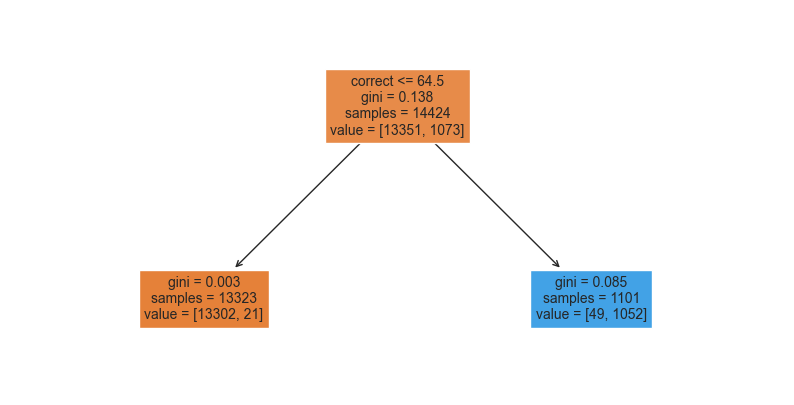

In [306]:
plt.figure(figsize=(10, 5))
plot_tree(best_clf, fontsize=10, feature_names=list(X_train), filled=True)
plt.show()

/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


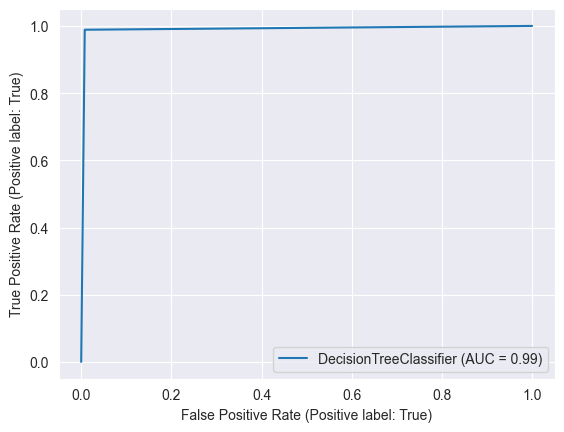

In [324]:
plot_roc_curve(best_clf, X_test, y_test)
plt.show()

/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


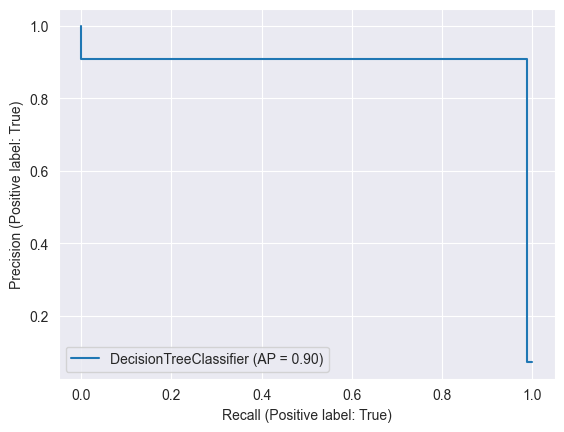

In [327]:
plot_precision_recall_curve(best_clf, X_test, y_test)
plt.show()

In [328]:
test_prob = best_clf.predict_proba(X_test)[:, 1]
test_pred = best_clf.predict(X_test)

In [330]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.03276
AUC = 0.99039
Average Precision = 0.89912

Using 0.5 as threshold:
Accuracy = 0.99189
Precision = 0.90862
Recall = 0.98864
F1 score = 0.94694

Classification Report
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      4457
        True       0.91      0.99      0.95       352

    accuracy                           0.99      4809
   macro avg       0.95      0.99      0.97      4809
weighted avg       0.99      0.99      0.99      4809



Confusion Matrix


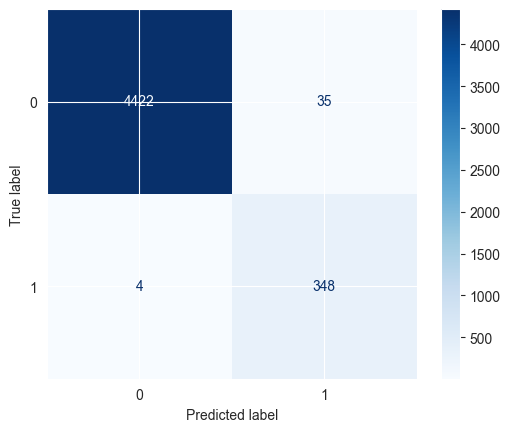

In [322]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

# Дополнительные задания

### Задача
Как я уже писал ранее, данные, с которыми мы работаем, обезличены, тоесть реальные id пользователей заменены случайным числом. Анонимизация пользовательских данных - очень важная тема для Data Science. С одной стороны мы хотим знать о поведении наших пользователей как можно больше, с другой стороны нам важно соблюдать приватность наших пользователей.

Поэтому данные о поведении пользователей анонимизируют не только когда речь идет об открытых данных, но и при работе с данными внутри компании. Не заметили сколько писем вам недавно пришло об изменении политики конфеденциальности, хотите узнать почему? В комментарии приложена ссылка на очень интересный доклад об этой проблеме.

А пока что вот вам хакерская задача, за каким вымышленным id скрывается Анатолий Карпов - автор курса, данные которого мы анализируем?

Введите id Анатолия Карпова, под которым он фигурирует в данных events_data_train и submissions_data_train.

In [41]:
events_train.groupby('user_id').aggregate({'action': 'count'})

,action
user_id,
1,2
2,30
3,400
5,38
7,3
...,...
26790,26
26793,3
26794,352


In [42]:
events_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [43]:
events_train[events_train.user_id == 20907].timestamp.min()

1434346645

In [44]:
events_train[events_train.user_id == 20907].timestamp.max()

1453480839

In [45]:
gap = events_train[events_train.user_id == 20907].timestamp.max() - events_train[events_train.user_id == 20907].timestamp.min()
gap = gap / (24 * 60 * 60)
gap

221.4605787037037

In [46]:
gap = events_train[events_train.action == 'viewed']

In [47]:
max_timestamp = gap.groupby('user_id').timestamp.apply(list).apply(max)

In [48]:
min_timestamp = gap.groupby('user_id').timestamp.apply(list).apply(min)

In [49]:
gap_t = pd.concat([min_timestamp, max_timestamp], axis=1, ignore_index=True)
gap_t.head()

,0,1
user_id,,
1,1472827464,1472827464
2,1514383364,1519226966
3,1434358476,1444581588
5,1466156809,1499859939
7,1521634660,1521634660


In [50]:
gap_t['gap'] = gap_t[1] - gap_t[0]
gap_t

,0,1,gap
user_id,,,
1,1472827464,1472827464,0
2,1514383364,1519226966,4843602
3,1434358476,1444581588,10223112
5,1466156809,1499859939,33703130
7,1521634660,1521634660,0
...,...,...,...
26790,1451484016,1517495987,66011971
26793,1510225031,1510225031,0
26794,1495287049,1512035039,16747990


In [51]:
unique_days = events_train.groupby('user_id')['day'].nunique()
unique_days

user_id
1        1
2        2
3        7
5        2
7        1
        ..
26790    4
26793    1
26794    9
26797    2
26798    1
Name: day, Length: 19234, dtype: int64

### Задача
В процессе решения одной аналитической задачи очень часто замечаешь и другие задачи, связанные с исследуемым вопросом. В свое время, работая над предсказанием оттока студентов со stepik, я многое изменил в структуре своих курсов.

Тогда я нашел довольно интересную закономерность прохождения онлайн курсов. Слушатели онлайн курсов очень негативно реагируют на невозможность решить задачу, иными словами, если студент застрял на определенном шаге, то он, с высокой вероятность, вообще бросит курс, чем просто пропустит этот шаг и продолжит обучение.

Давайте найдем такой стэп, используя данные о сабмитах. Для каждого пользователя найдите такой шаг, который он не смог решить, и после этого не пытался решать другие шаги. Затем найдите id шага,  который стал финальной точкой практического обучения на курсе для максимального числа пользователей.

То есть мы исследуем следующий сценарий: человек решает стэп, не может получить правильный ответ и больше не возвращается к практическим задачам. Что это за шаг такой, который отпугнул максимальное число пользователей?

In [94]:
submissions_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [123]:
submissions_train.groupby(['step_id', 'submission_status']).aggregate({'user_id': 'count'}).reset_index().query("submission_status == 'wrong' & user_id == user_id.max()")

,step_id,submission_status,user_id
9,31978,wrong,16084


In [133]:
submissions_train.mode()

,step_id,timestamp,submission_status,user_id,date,day
0,31978,1491590313,wrong,12265,2017-04-07 18:38:33,2015-07-06


In [134]:
submissions_train.sort_values(['user_id', 'timestamp'], ascending=False).drop_duplicates(['user_id'])\
        .query("submission_status == 'wrong'").groupby('step_id')\
        .count().sort_values('submission_status').tail(1)

,timestamp,submission_status,user_id,date,day
step_id,,,,,
31978,154,154,154,154,154


### Соревнование
Мы начинаем соревнование!

Задача нам уже знакома - нужно предсказать, сможет ли пользователь успешно закончить онлайн курс Анализ данных в R.

Мы будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.

В данных:

submission_data_test.csv
events_data_test.csv
хранится информация о решениях и действиях для 6184 студентов за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019. Подробное описание переменных смотри в этом шаге.

Используя данные о первых двух днях активности на курсе вам нужно предсказать, наберет ли пользователь более 40 баллов на курсе или нет.

В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание. На самом деле, используя эти данные, вы уже можете сделать прогноз. Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем. Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса, где для всех пользователей представлены все данные об их активности на курсе.


Итогом вашей работы должен стать csv файл c предсказанием для каждого студента из тестовых данных. Пример предсказания выглядит следующим образом.

Чтобы узнать точность ваших предсказаний, в качестве решения этого шага отпраьте файл с предсказаниями для каждого студента в указанном выше формате.

Убедитесь, что вы сформировали файл с предсказаними для всех 6184 студентов, для каждого студента должна быть предсказана вероятность, что он наберет более 40 баллов за курс. У вас есть 25 попыток засабмитить решения, в зачет пойдет наилучший вариант.

Результатом проверки этого задания будет значение ROC AUC score, именно по этому показателю мы и отберем победителей, успехов!

In [812]:
fpr, tpr, _ = roc_curve(y_train, predictions_proba)

In [813]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [814]:
pr, rc, _ = precision_recall_curve(y_train, predictions_proba)

In [815]:
plt.plot(pr, rc)
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [816]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [804]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [462]:
predictions_proba_train = model.predict(X_train)

In [463]:
predictions_train = (model.predict(X_train) > 0.5).astype(int)

In [464]:
print('Log loss = {:.5f}'.format(log_loss(y_train, predictions_proba_train)))
print('AUC = {:.5f}'.format(roc_auc_score(y_train, predictions_proba_train)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_train, predictions_proba_train)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_train, predictions_train)))
print('Precision = {:.5f}'.format(precision_score(y_train, predictions_train)))
print('Recall = {:.5f}'.format(recall_score(y_train, predictions_train)))
print('F1 score = {:.5f}'.format(f1_score(y_train, predictions_train)))

print('\nClassification Report')
print(classification_report(y_train, predictions_train))

In [817]:
export_data = pd.concat([pd.Series(users_data_contest.user_id), pd.DataFrame(predictions_proba)], axis=1)

In [818]:
export_data.columns = ['user_id', 'is_gone']

In [819]:
export_data.head()

In [820]:
export_data.to_csv('/Users/mitya/out.csv', index=False)

=================================

### Попытка # 2

In [110]:
events_test_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')

In [111]:
submissions_test_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [344]:
events_test_contest = events_test_data

In [345]:
submissions_test_contest = submissions_test_data

In [346]:
submissions_test_contest.info()

In [347]:
events_test_contest.user_id.nunique()

In [348]:
submissions_test_contest.user_id.nunique()

In [349]:
events_test_contest['date'] = pd.to_datetime(events_test_contest.timestamp, unit='s')

In [350]:
events_test_contest['day'] = events_test_contest.date.dt.date

In [351]:
events_test_contest.info()

In [352]:
events_test_contest = events_test_contest.drop_duplicates(subset=['user_id', 'step_id', 'action'])

In [353]:
submissions_test_contest['date'] = pd.to_datetime(submissions_test_contest.timestamp, unit='s')

In [354]:
submissions_test_contest['day'] = submissions_test_contest.date.dt.date

In [355]:
# submissions_test_contest = submissions_test_contest.drop_duplicates(subset=['user_id', 'step_id', 'submission_status'], keep='first')
submissions_test_contest = submissions_test_contest[~(submissions_test_contest.duplicated(['user_id', 'step_id', 'submission_status']) & submissions_test_contest.submission_status.eq('correct'))]

In [356]:
first_timestamp = events_test_contest[['user_id', 'timestamp']].groupby('user_id').aggregate({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'first_timestamp'})

In [357]:
first_timestamp.head()

In [358]:
events_test_contest = events_test_contest.merge(first_timestamp, on='user_id', how='outer').fillna(0)

In [359]:
events_test_contest.first_timestamp.info()

In [360]:
submissions_test_contest = submissions_test_contest.merge(first_timestamp, on='user_id', how='left').fillna(0)

In [361]:
timestamp_threshold = 2 * 24 * 60 * 60

In [362]:
events_test_contest['first_two_days'] = events_test_contest.timestamp <= events_test_contest.first_timestamp + timestamp_threshold

In [363]:
events_test_contest = events_test_contest[events_test_contest.first_two_days == True]

In [364]:
events_test_contest.head()

In [365]:
submissions_test_contest['first_two_days'] = submissions_test_contest.timestamp <= submissions_test_contest.first_timestamp + timestamp_threshold

In [366]:
submissions_test_contest.head()

In [367]:
submissions_test_contest.first_two_days.nunique()

In [368]:
submissions_test_contest = submissions_test_contest[submissions_test_contest.first_two_days == True]

In [369]:
start_day_submissions = submissions_test_contest[['user_id', 'day']].groupby('user_id').aggregate({'day': 'min'}).reset_index().rename(columns={'day': 'start_day'})

In [370]:
submissions_test_contest = submissions_test_contest.merge(start_day_submissions, on='user_id', how='outer').fillna(0)

In [371]:
submissions_test_contest['day_number'] = submissions_test_contest.day - submissions_test_contest.start_day

In [372]:
# submissions_test_contest = submissions_test_contest[(submissions_train.day_number == '0 days') | (submissions_test_contest.day_number == '1 days')]

In [373]:
submissions_pivot_table = submissions_test_contest.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [374]:
submissions_pivot_table['course_complete'] = submissions_pivot_table.correct > 40

In [375]:
submissions_pivot_table.groupby('course_complete').aggregate({'user_id': 'count'})

In [376]:
# submissions_pivot_table.groupby('course_complete').aggregate({'user_id': 'count'})

In [377]:
#  submissions_first_two_days = submissions_test_contest[(submissions_test_contest.day_number == '0 days') | (submissions_test_contest.day_number == '1 days')]

submissions_first_two_days = submissions_test_contest[submissions_test_contest.first_two_days == True]

In [378]:
submissions_first_two_days.first_two_days.nunique()

In [379]:
submissions_first_two_days.info()

In [380]:
submissions_first_two_days.user_id.nunique()

In [381]:
submissions_first_two_days_pivot_table = submissions_first_two_days.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [382]:
submissions_first_two_days_pivot_table.correct.sum()

In [383]:
submissions_pivot_table = submissions_pivot_table.drop(['correct', 'wrong'], axis=1)

In [384]:
# В итоговую таблицу попадают пользователи успешно прошедшие курс, которые проходили практические задания первые два дня
submissions_pivot_table = submissions_pivot_table[['user_id', 'course_complete']].merge(submissions_first_two_days_pivot_table, on='user_id', how='outer').fillna(0)

# submissions_pivot_table = submissions_first_two_days_pivot_table

#

In [385]:
submissions_pivot_table.head()

In [386]:
submissions_pivot_table.nunique()

In [387]:
submissions_pivot_table.groupby('course_complete').aggregate({'user_id': 'count'})

In [388]:
submissions_pivot_table.user_id.nunique()

In [389]:
submissions_first_day = submissions_test_contest[submissions_test_contest.timestamp <= submissions_test_contest.first_timestamp + 24 * 60 * 60].pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'correct': 'first_day_correct', 'wrong': 'first_day_wrong'})

In [390]:
submissions_first_day.head()

In [391]:
submissions_second_day = submissions_test_contest[(submissions_test_contest.timestamp > submissions_test_contest.first_timestamp + 24 * 60 * 60) & (submissions_test_contest.timestamp <= submissions_test_contest.first_timestamp + 2 * 24 * 60 * 60)].pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'correct': 'second_day_correct', 'wrong': 'second_day_wrong'})

In [392]:
submissions_second_day.head()

In [393]:
submissions_second_day.second_day_correct.sum() + submissions_first_day.first_day_correct.sum()

In [394]:
submissions_pivot_table.correct.sum()

In [395]:
retention = submissions_first_day.merge(submissions_second_day, on='user_id', how='outer').fillna(0)

In [396]:
retention = retention.merge(submissions_pivot_table, on='user_id', how='outer').fillna(0)

In [397]:
retention.columns

In [398]:
retention.user_id.nunique()

In [399]:
# retention.groupby('course_complete').aggregate({'user_id': 'count'})

In [400]:
# start_day_events = events_test_contest[['user_id', 'day']].groupby('user_id').aggregate({'day': 'min'}).reset_index().rename(columns={'day': 'start_day'})

In [401]:
# events_test_contest = events_test_contest.merge(start_day_events, on='user_id', how='outer').fillna(0)

In [402]:
retention_events_pivot = events_test_contest.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [403]:
# retention_events_pivot['course_complete'] = retention_events_pivot.passed > 170

In [404]:
# retention_events_pivot = retention_events_pivot.drop(['discovered', 'passed', 'started_attempt', 'viewed'], axis=1)

In [405]:
# retention_events_pivot.groupby('course_complete').agg({'user_id': 'count'})

In [406]:
# events_test_contest['day_number'] = events_test_contest.day - events_test_contest.start_day

In [407]:
events_test_contest.info()

In [408]:
events_first_two_days = events_test_contest[events_test_contest.first_two_days == True]

In [409]:
events_first_two_days.info()

In [410]:
events_first_two_days_pivot = events_first_two_days.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [411]:
events_first_two_days_pivot.head()

In [412]:
events_first_day = events_first_two_days[events_first_two_days.timestamp <= events_first_two_days.first_timestamp + 24 * 60* 60].pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'viewed': 'first_day_viewed', 'passed': 'first_day_passed', 'discovered': 'first_day_discovered', 'started_attempt':'first_day_started_attempt'})

In [413]:
events_second_day = events_first_two_days[(events_first_two_days.timestamp > events_first_two_days.first_timestamp + 24 * 60* 60)&(events_first_two_days.timestamp <= events_first_two_days.first_timestamp + 2 * 24 * 60* 60)].pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'viewed': 'second_day_viewed', 'passed': 'second_day_passed', 'discovered': 'second_day_discovered', 'started_attempt':'second_day_started_attempt'})

In [414]:
events_first_two_days_pivot[events_first_two_days_pivot.user_id == 11561]

In [415]:
events_first_day[events_first_day.user_id == 11561]

In [416]:
events_second_day[events_second_day.user_id == 11561]

In [417]:
events_first_day.first_day_passed.sum() + events_second_day.second_day_passed.sum()

In [418]:
events_first_two_days_pivot.passed.sum()

In [419]:
# retention_events_pivot = retention_events_pivot.merge(events_first_two_days_pivot, on='user_id', how='outer').fillna(0)

In [420]:
retention_events_pivot = retention_events_pivot.merge(events_first_day, on='user_id', how='outer').fillna(0)

In [421]:
retention_events_pivot.head()

In [422]:
retention_events_pivot = retention_events_pivot.merge(events_second_day, on='user_id', how='outer').fillna(0)

In [423]:
retention_events_pivot[['correct', 'wrong', 'discovered', 'passed', 'started_attempt', 'viewed',
       'day', 'course_complete']]

In [424]:
retention_events_pivot.groupby('course_complete').agg({'user_id': 'count'})

In [425]:
events_test_contest.user_id.nunique()

In [426]:
events_first_two_days.user_id.nunique()

In [427]:
retention_events_pivot.user_id.nunique()

In [428]:
# retention_events_pivot.groupby('course_complete').agg({'user_id': 'count'})

In [429]:
retention = retention.merge(retention_events_pivot, on='user_id', how='outer').fillna(0)

In [430]:
retention[['correct', 'wrong', 'discovered', 'passed', 'started_attempt', 'viewed',
       'day', 'course_complete']]

In [2026]:
submissions_pivot_table.groupby('course_complete').aggregate({'user_id': 'count'})

In [431]:
retention.groupby('course_complete').agg({'user_id': 'count'})

In [2028]:
retention.columns

In [2029]:
retention['correct_ratio'] = (retention.second_day_correct / retention.first_day_correct).fillna(0)

In [2030]:
retention['wrong_ratio'] = (retention.second_day_wrong / retention.first_day_wrong).fillna(0)

In [2031]:
retention['discovered_ratio'] = (retention.second_day_discovered / retention.first_day_discovered).fillna(0)

In [2032]:
retention['passed_ratio'] = (retention.second_day_passed / retention.first_day_passed).fillna(0)

In [2033]:
retention['started_attempt_ratio'] = (retention.second_day_started_attempt / retention.first_day_started_attempt).fillna(0)

In [2034]:
retention['viewed_ratio'] = (retention.second_day_viewed / retention.first_day_viewed).fillna(0)

In [2035]:
retention.replace([np.inf, -np.inf], 0, inplace=True)

In [2036]:
retention_clear = retention.drop(['first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'first_day_discovered',
       'first_day_passed', 'first_day_started_attempt', 'first_day_viewed',
       'second_day_discovered', 'second_day_passed',
       'second_day_started_attempt', 'second_day_viewed'], axis=1)

In [2037]:
retention.head()

In [2038]:
retention_clear.head()

In [2039]:
retention.columns

In [2040]:
retention_clear.columns

In [2041]:
retention.groupby('course_complete').aggregate({'user_id':'count'})

In [1352]:
# retention[(retention.passed >= 8) | (retention.correct > 1)].count()

In [1353]:
# retention[(retention.passed < 8) | (retention.correct <= 1)].count()

In [359]:
# retention[(retention.course_complete == False) & (retention.correct < 10)].correct.hist()

### Test Data Preparation

In [2118]:
events_train_contest = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')

In [2119]:
submission_train_contest = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')

In [2120]:
events_train_contest['date'] = pd.to_datetime(events_train_contest.timestamp, unit='s')

In [2121]:
events_train_contest['day'] = events_train.date.dt.date

In [2122]:
submission_train_contest['date'] = pd.to_datetime(submission_train_contest.timestamp, unit='s')

In [2123]:
submission_train_contest['day'] = submission_train_contest.date.dt.date

In [2124]:
start_day_events = events_train_contest[['user_id', 'day']].groupby('user_id').aggregate({'day': 'min'}).reset_index().rename(columns={'day': 'start_day'})

In [2125]:
start_day_submissions = submission_train_contest[['user_id', 'day']].groupby('user_id').aggregate({'day': 'min'}).reset_index().rename(columns={'day': 'start_day'})

In [2126]:
events_train_contest = events_train_contest.merge(start_day_events, on='user_id', how='outer').fillna(0)

In [2127]:
events_train_contest['day_number'] = events_train_contest.day - events_train_contest.start_day

In [2128]:
submission_train_contest = submission_train_contest.merge(start_day_submissions, on='user_id', how='outer').fillna(0)

In [2129]:
submission_train_contest['day_number'] = submission_train_contest.day - submission_train_contest.start_day

In [2131]:
first_timestamp_events_train = events_train_contest.groupby('user_id').aggregate({'timestamp': 'min'}).reset_index().rename(columns={'timestamp': 'first_timestamp'})

In [2132]:
first_timestamp_events_train.head()

In [2133]:
events_train_contest = events_train_contest.merge(first_timestamp_events_train, on='user_id', how='outer').fillna(0)

In [2076]:
events_first_day_sm = events_train_contest[events_train_contest.day_number == '0 days'].pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'viewed': 'first_day_viewed', 'passed': 'first_day_passed', 'discovered': 'first_day_discovered', 'started_attempt':'first_day_started_attempt'})

In [2077]:
events_second_day_sm = events_train_contest[events_train_contest.day_number == '1 days'].pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'viewed': 'second_day_viewed', 'passed': 'second_day_passed', 'discovered': 'second_day_discovered', 'started_attempt':'second_day_started_attempt'})

In [2078]:
events_pivot_sm = events_train_contest.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [2079]:
events_pivot_sm = events_pivot_sm.merge(events_first_day_sm, on='user_id', how='outer').fillna(0)

In [2080]:
events_pivot_sm = events_pivot_sm.merge(events_second_day_sm, on='user_id', how='outer').fillna(0)

In [2081]:
submission_first_day_sm = submission_train_contest[submission_train_contest.day_number == '0 days'].pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'correct': 'first_day_correct', 'wrong': 'first_day_wrong'})

In [2082]:
submissions_second_day_sm = submission_train_contest[submission_train_contest.day_number == '1 days'].pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().rename(columns={'correct': 'second_day_correct', 'wrong': 'second_day_wrong'})

In [2083]:
submissions_pivot_sm = submission_train_contest.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [2084]:
submissions_pivot_sm = submissions_pivot_sm.merge(submission_first_day_sm, on='user_id', how='outer').fillna(0)

In [2085]:
submissions_pivot_sm = submissions_pivot_sm.merge(submissions_second_day_sm, on='user_id', how='outer').fillna(0)

In [2086]:
retention_sm = events_pivot_sm.merge(submissions_pivot_sm, on='user_id', how='outer').fillna(0)

In [2087]:
retention_sm['correct_ratio'] = (retention_sm.second_day_correct / retention_sm.first_day_correct).fillna(0)

In [2088]:
retention_sm['wrong_ratio'] = (retention_sm.second_day_wrong / retention_sm.first_day_wrong).fillna(0)

In [2089]:
retention_sm['discovered_ratio'] = (retention_sm.second_day_discovered / retention_sm.first_day_discovered).fillna(0)

In [2090]:
retention_sm['passed_ratio'] = (retention_sm.second_day_passed / retention_sm.first_day_passed).fillna(0)

In [2091]:
retention_sm['started_attempt_ratio'] = (retention_sm.second_day_started_attempt / retention_sm.first_day_started_attempt).fillna(0)

In [2092]:
retention_sm['viewed_ratio'] = (retention_sm.second_day_viewed / retention_sm.first_day_viewed).fillna(0)

In [2093]:
retention_sm.replace([np.inf, -np.inf], 0, inplace=True)

In [2094]:
retention_clear_sm = retention_sm.drop(['first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'first_day_discovered',
       'first_day_passed', 'first_day_started_attempt', 'first_day_viewed',
       'second_day_discovered', 'second_day_passed',
       'second_day_started_attempt', 'second_day_viewed'], axis=1)

In [2095]:
retention_clear_sm.head()

In [2097]:
retention_sm.columns

In [2101]:
X_test = retention_sm.drop(['first_day_correct', 'first_day_wrong', 'second_day_correct',
       'second_day_wrong', 'correct_ratio', 'wrong_ratio', 'discovered_ratio',
       'passed_ratio', 'started_attempt_ratio', 'viewed_ratio'], axis=1)

In [1354]:
retention_clear.groupby('course_complete').agg({'user_id': 'count'})

In [1069]:
retention_clear[['user_id', 'correct', 'wrong', 'course_complete', 'discovered',
       'passed', 'started_attempt', 'viewed']]

In [1041]:
retention.info()

In [2042]:
X_train = retention.drop(['course_complete', 'correct_ratio', 'wrong_ratio', 'discovered_ratio', 'passed_ratio', 'started_attempt_ratio', 'viewed_ratio'], axis=1)
# X_train = retention[['correct', 'user_id', 'passed']]
# 'discovered', 'correct_ratio', 'wrong_ratio', 'discovered_ratio', 'passed_ratio', 'started_attempt_ratio', 'viewed_ratio', 'correct', 'wrong', 'passed', 'started_attempt', 'viewed'

In [2044]:
X_train.head()

In [2045]:
X_train = X_train.set_index('user_id')

In [2046]:
y_train = retention['course_complete']

In [2047]:
y_train = y_train.map({True: 1, False: 0})

In [1048]:
X_test = retention_clear_sm

In [2102]:
X_test = X_test.set_index('user_id')

In [2051]:
scaler = StandardScaler()
scaler.fit(X_train)

In [2052]:
X_train = scaler.transform(X_train)

In [2050]:
X_train

In [2103]:
scaler = StandardScaler()
scaler.fit(X_test)

In [2104]:
X_test = scaler.transform(X_test)

In [2053]:
n_features = X_train.shape[1]
model = Sequential()
model.add(Dense(int(round((n_features+1)/2)), input_shape=(n_features,), activation='relu'))
model.add(Dense(int(round((n_features+1)/4)), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [2054]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [2055]:
model.fit(X_train, y_train, epochs=10, batch_size=10)

In [ ]:
predictions_proba = model.predict(X_test)

In [2106]:
predictions_proba

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype(int)

In [2058]:
print('Log loss = {:.5f}'.format(log_loss(y_train, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_train, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_train, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_train, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_train, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_train, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_train, predictions)))

print('\nClassification Report')
print(classification_report(y_train, predictions))

In [455]:
print('Log loss = {:.5f}'.format(log_loss(y_test, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_test, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_test, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_test, predictions)))

print('\nClassification Report')
print(classification_report(y_test, predictions))

In [2059]:
fpr, tpr, _ = roc_curve(y_train, predictions_proba)

In [2060]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [2061]:
pr, rc, _ = precision_recall_curve(y_train, predictions_proba)

In [2062]:
plt.plot(pr, rc)
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [2063]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [2114]:
export_data = pd.concat([retention_sm.user_id, pd.DataFrame(predictions_proba)], axis=1)

In [2115]:
export_data.columns = ['user_id', 'is_gone']

In [2116]:
export_data.head()

In [2117]:
export_data.to_csv('/Users/mitya/out.csv', index=False)

### Дерево решений

In [1768]:
clf = DecisionTreeClassifier()

In [1769]:
params={'criterion':['gini', 'entropy'], 'max_depth': range(5, 12)}

In [1770]:
grid_search_cv_clf=GridSearchCV(clf, params, cv=5)

In [1771]:
grid_search_cv_clf.fit(X_train, y_train)

In [1772]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

In [1773]:
grid_search_cv_clf.best_params_

In [1774]:
best_clf.fit(X_train, y_train)

In [1775]:
predictions_proba = best_clf.predict_proba(X_train)[:, 1]

In [1776]:
predictions = best_clf.predict(X_train)

In [1777]:
print('Log loss = {:.5f}'.format(log_loss(y_train, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_train, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_train, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_train, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_train, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_train, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_train, predictions)))

print('\nClassification Report')
print(classification_report(y_train, predictions))

In [1767]:
plt.show()
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [1778]:
fpr, tpr, _ = roc_curve(y_train, predictions_proba)

In [1779]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [1780]:
pr, rc, _ = precision_recall_curve(y_train, predictions_proba)

In [1781]:
plt.plot(pr, rc)
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,)
plt.ylim(0,)
plt.show()